# CS638 Vision Zero Madison

### Author: Clarence (Ming Hsuan), Kuo
#### Group: 2


## Scratch Work

### Fisrt Question: What can be the major factor that makes car crash happen?

### Potential factors:
- Weather Conditions ex: Snow, Rain, Hot day etc
- School season ex: Summer/Winter break, Fall/Spring semester
- Government Policy ex: Drunk and drive policy

#### Background found by my teammates

1. Most of the accidents are labeled "Property Damaged", which are minor accidents.
2. If catogorizing the data into intersect and non-intersect, the split is 55%/45%.

In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
#from matplotlib.dates import date2num
import seaborn as sns
import chart_studio.plotly as py
import plotly.tools as tls
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')
from collections import deque

# read data
df = pd.read_csv('Madison_crash_2009_2019.csv')

#Constant Definition
fontSize = 30
labelSize = fontSize + 3
titleSize = fontSize + 5

##### Preparing data

Get month and year bin

In [2]:
dftime= pd.to_datetime(df["ACCDDATE"])
df["ACCDMONTH"] = ""
df["ACCDYEAR"] = ""
for i in range(len(dftime)):
    #get month bin
    df["ACCDMONTH"][i] = dftime[i].month
    if dftime[i].year != 2019:
        #get year bin
        df["ACCDYEAR"][i] = dftime[i].year
    else:
        df["ACCDYEAR"][i] = None


In [3]:
# Create fatal case data
df["FATALFLAG"] = ""
df["INJFLAG"] = ""
for i in range(len(df["ACCDSVR"])):
    #print(df["ACCDSVR"][i])
    if df["ACCDSVR"][i] == 'FAT':
        df["FATALFLAG"][i] = 'FAT'
        df["INJFLAG"][i] = None
    elif df["ACCDSVR"][i] == 'INJ':
        df["INJFLAG"][i] = 'INJ'
        df["FATALFLAG"][i] = None
    else:
        df["FATALFLAG"][i] = None
        df["INJFLAG"][i] = None

In [4]:
# Create fatal case data
df["SUMMERFATALFLAG"] = ""
df["SUMMERINJFLAG"] = ""
df["SUMMER"] = ""
SUM_FAT = 0
SUM_INJ = 0
for i in range(len(dftime)):
    if 5 < dftime[i].month < 10:
        if df["FATALFLAG"][i] != None:
            df["SUMMERFATALFLAG"][i] = "FAT"
            df["SUMMER"][i] = "FAT"
            SUM_FAT += 1
        else:
            df["SUMMERFATALFLAG"][i] = None
            df["SUMMER"][i] = None
            
        if df["INJFLAG"][i] != None:
            df["SUMMERINJFLAG"][i] = "INJ"
            df["SUMMER"][i] = "INJ"
            SUM_INJ += 1
        else:
            df["SUMMERINJFLAG"][i] = None
            
        if df["INJFLAG"][i] == None and df["FATALFLAG"][i] == None:
            df["SUMMER"][i] = None
    else:
        df["SUMMERFATALFLAG"][i] = None
        df["SUMMERINJFLAG"][i] = None
        df["SUMMER"][i] = None


### Accident location analysis
- plot the accient by latitude and longtitude to check if there is a clustered area.

In [ ]:
import plotly
import plotly.graph_objects as go
import gmplot
plotly.offline.init_notebook_mode(connected = True)
mapbox_access_token = 'pk.eyJ1IjoicnlhbnlhbmciLCJhIjoiY2swaDI5cmt0MDdpeTNkcDhwdDFmMmgwMyJ9.k-gVR4ZYPtS4YVranuGJXA'
#get data with lat and long
LOC_SUMMERINJFLAG = df.groupby(['ACCDTYPE','SUMMERINJFLAG','WISLR_LATDECDG','WISLR_LONDECDG']).count()['DOCTNMBR'].to_frame().reset_index()
loc_na_dropped_df = LOC_SUMMERINJFLAG.dropna(subset=['WISLR_LATDECDG', 'WISLR_LONDECDG'])
lat = loc_na_dropped_df['WISLR_LATDECDG']
lon = loc_na_dropped_df['WISLR_LONDECDG']
fig = go.Figure(go.Scattermapbox(lat = lat, lon = lon,
                         mode = 'markers',
                         marker = go.scattermapbox.Marker(size=3,color='rgb(0, 100, 100)'),
                         text = loc_na_dropped_df['SUMMERINJFLAG']))
fig.update_layout(title = 'Injuried Accident From May to October',
                   autosize = True,
                   hovermode = 'closest',
                   showlegend = False,
                   mapbox = dict(accesstoken = mapbox_access_token,
                                 bearing = 0,
                                 center = dict(lat = 43.07, lon = -89.43),
                                 pitch = 0,
                                 zoom = 9.5,
                                 style = 'light'))
plotly.offline.iplot(fig)
%%capture

In [35]:
import geopandas as gpd
import shapefile as shp

sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))
#opening the vector map
shp_path = '/Users/ark.kuo/Project/DS/Vision-Zero-Madison/Madison-shp/shape/roads.shp'
#reading the shape file by using reader function of the shape lib
sf = shp.Reader(shp_path)
len(sf.shapes())

45676

In [9]:
def read_shapefile(sf):
    #fetching the headings from the shape file
    fields = [x[0] for x in sf.fields][1:]
#fetching the records from the shape file
    records = [list(i) for i in sf.records()]
    shps = [s.points for s in sf.shapes()]
#converting shapefile data into pandas dataframe
    df = pd.DataFrame(columns=fields, data=records)
#assigning the coordinates
    df = df.assign(coords=shps)
    return df

In [37]:
geo_df = read_shapefile(sf)
geo_df

,osm_id,name,ref,type,oneway,bridge,maxspeed,coords
0,4705464,Mineral Point Road,,secondary,1,0,NaN,"[(-89.5026705, 43.0606153), (-89.502535, 43.06..."
1,4709908,,I 39;I 90,motorway,1,0,70.0,"[(-89.2857692, 43.1100579), (-89.2856319, 43.1..."
2,4709949,,,motorway_link,1,0,NaN,"[(-89.2966402, 43.1368517), (-89.296816, 43.13..."
3,4710035,,,motorway_link,1,0,NaN,"[(-89.3008209, 43.1335121), (-89.3010083, 43.1..."
4,4710039,American Parkway,,tertiary,1,0,NaN,"[(-89.2826145, 43.1446071), (-89.2827921, 43.1..."
...,...,...,...,...,...,...,...,...
45671,738570666,Notre Dame Drive,,construction,0,0,NaN,"[(-89.4088611, 42.9967685), (-89.4090685, 42.9..."
45672,738570667,Holstein Lane,,construction,0,0,NaN,"[(-89.4100938, 42.9975421), (-89.4100497, 42.9..."
45673,738702608,,,service,0,0,NaN,"[(-89.5037216, 43.0612261), (-89.5037189, 43.0..."
45674,738702609,,,service,0,0,NaN,"[(-89.5045853, 43.0612288), (-89.5037216, 43.0..."


In [ ]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (11,9)):
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            #plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

KeyboardInterrupt: 

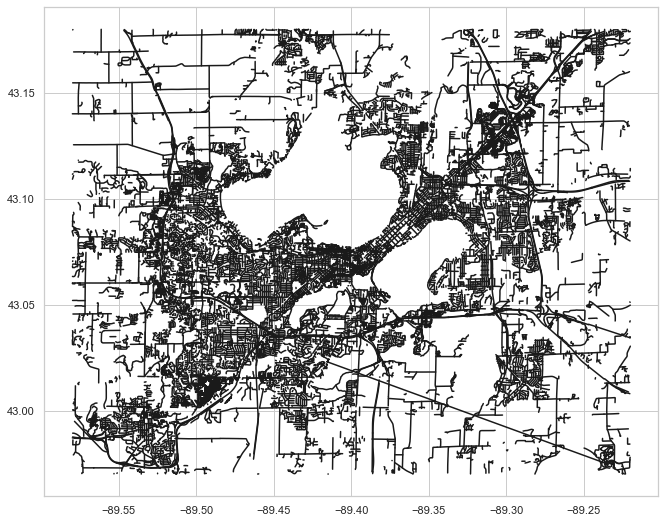

In [36]:
#calling the function and passing required parameters to plot the full map
plot_map(sf)

In [24]:
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']